# Compte-Rendu de Travail :

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import sklearn.metrics as met
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso

J'ai commencé par fusionner les différents csv, pour pouvoir travailler sur un seul et même fichier, grâce à la commande :
                                    // cat *.csv > combined.csv //

In [4]:
data = pd.read_csv('csv/combined.csv', sep=';')
print(data.head())

    id_mutation date_mutation  numero_disposition nature_mutation  \
0   2022-360375    21/04/2022                   1           Vente   
1   2022-360375    21/04/2022                   1           Vente   
2  2021-1180016    10/05/2021                   1           Vente   
3  2021-1177880    14/01/2021                   1           Vente   
4  2021-1177880    14/01/2021                   1           Vente   

   valeur_fonciere  adresse_numero adresse_suffixe      adresse_nom_voie  \
0         260000.0            26.0            None           RUE DELILLE   
1         260000.0            26.0            None           RUE DELILLE   
2         160000.0            13.0            None  RUE ALFRED DE MUSSET   
3         174000.0            21.0            None     RUE PAUL VERLAINE   
4         174000.0            21.0            None     RUE PAUL VERLAINE   

  adresse_code_voie code_postal  ...  surface_reelle_bati  \
0               582       76800  ...                129.0   
1     

On peut cibler directement les colonnes que l'on souhaite garder, qui nous semble pertinentes :

<AxesSubplot:>

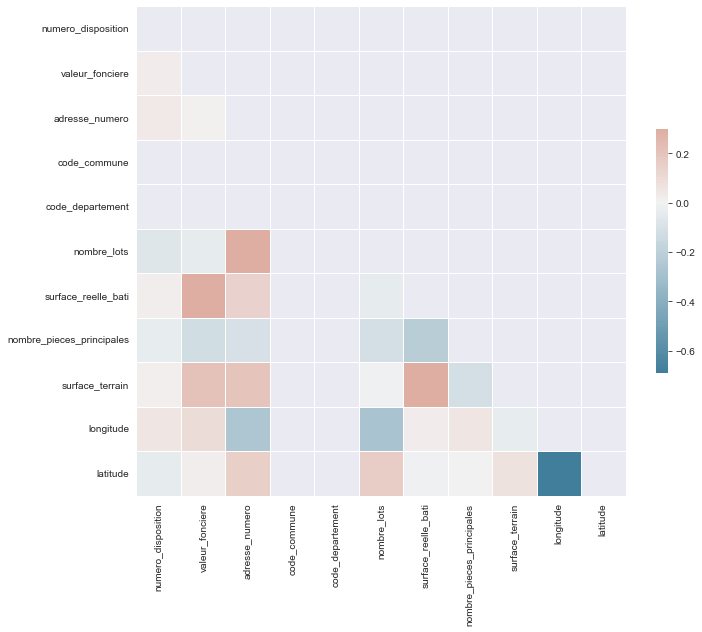

In [5]:
mat_corr = data.corr()
mask = np.triu(np.ones_like(mat_corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

On voit bien avec la matrice de corrélation, l'importance de chaque caractéristique. On peut donc enlever les non-pertinentes :

In [6]:
data = data.drop(['code_postal', 'section_prefixe', 'id_parcelle', 'adresse_code_voie', 'adresse_nom_voie', 'date_mutation', 'adresse_suffixe', 'id_mutation', 'nature_mutation', 'code_commune', 'code_departement', 'nombre_lots', 'numero_disposition', 'code_commune', 'code_departement', 'nom_commune', 'ancien_code_commune', 'ancien_nom_commune', 'ancien_id_parcelle', 'numero_volume', 'lot1_numero', 'lot1_surface_carrez', 'lot2_numero', 'lot2_surface_carrez', 'lot3_numero', 'lot3_surface_carrez', 'lot4_numero', 'lot4_surface_carrez', 'lot5_numero', 'lot5_surface_carrez', 'code_type_local', 'code_nature_culture', 'code_nature_culture_speciale', 'nature_culture', 'nature_culture_speciale'], axis=1)

On peut remarquer qu'il y a beaucoup de "None", dans certaines colonnes. Comme elles n'apportaient que peu d'information, j'ai décidé de les retirer pour faciliter le traitement des données :

In [7]:
data.dropna(inplace=True)
data = pd.DataFrame.reset_index(data, drop=True)
data.loc[data.type_local=='Maison','type_local']='0'
data.loc[data.type_local=='Appartement','type_local']='1'
data.loc[data.type_local=='Local industriel. commercial ou assimilé','type_local']='2'
print(data)

      valeur_fonciere  adresse_numero type_local  surface_reelle_bati  \
0            260000.0            26.0          0                129.0   
1            160000.0            13.0          0                 64.0   
2            174000.0            21.0          0                 64.0   
3            200000.0             2.0          1                 18.0   
4            200000.0             2.0          2                 68.0   
...               ...             ...        ...                  ...   
1318         189300.0            20.0          0                 80.0   
1319              1.2           520.0          2               3544.0   
1320        1000000.0          9010.0          1                 87.0   
1321        1000000.0          9010.0          2               1048.0   
1322         665000.0           165.0          2                600.0   

      nombre_pieces_principales  surface_terrain  longitude   latitude  
0                           4.0            351.0  

Après avoir nettoyé ces données, on va pouvoir les afficher :

In [8]:
carte = folium.Map(location=[49.38, 1.085], zoom_start=13.1, tiles='stamenterrain')
points = folium.FeatureGroup(name='Points')

longitude = data.longitude.values
latitude = data.latitude.values
Val_Fonc = data.valeur_fonciere.values

for i in range(len(data)):
    folium.CircleMarker(
        location = [latitude[i], longitude[i]],
        fill = True,
        fill_opacity = 0.6,
        radius = 6
    ).add_to(points)
    # folium.Marker([latitude[i], longitude[i]], popup="<i>Mt. Hood Meadows</i>").add_to(points)


points.add_to(carte)

carte


On a pu représenter les données géographiquement. Représentons les graphiquement maintenant :

In [9]:
data_train, data_test = train_test_split(data, train_size=0.7, test_size=0.3, random_state=10)

In [10]:
X_train = data_train
X_train = X_train.drop('valeur_fonciere', axis=1)
Y_train = data_train['valeur_fonciere']

In [11]:
X_test = data_test
X_test = X_test.drop('valeur_fonciere', axis=1)
Y_test = data_test['valeur_fonciere']

Avec la méthode de régression linéaire :

In [594]:
RegLin = LinearRegression()
scores = cross_val_score(RegLin, X_train, Y_train, cv=5)
print(scores)

[-0.51182407  0.38749416  0.0522892   0.51394808 -0.36887767]


0.6047858432682514


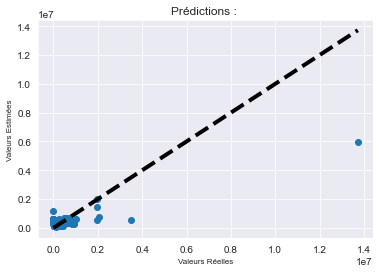

In [13]:
RegLin.fit(X_train, Y_train)
Y_final = RegLin.predict(X_test)
r2 = met.r2_score(Y_test, Y_final)
print(r2)


fig, ax = plt.subplots()
ax.scatter(Y_test, Y_final)
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel('Valeurs Réelles', fontsize=8)
ax.set_ylabel('Valeurs Estimées', fontsize=8)
ax.set_title('Prédictions : ')
plt.show()

Avec la méthode Lasso :

In [14]:
Lasso = Lasso()
scores = cross_val_score(Lasso, X_train, Y_train, cv=5)
print(scores)

[-0.51177099  0.38759089  0.05263721  0.51384679 -0.3690038 ]


0.6048248300518502


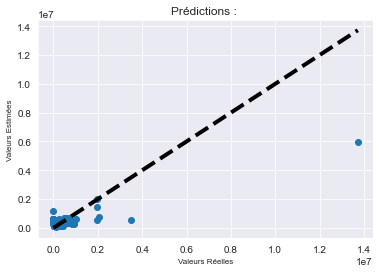

In [15]:
Lasso.fit(X_train, Y_train)
Y_final = Lasso.predict(X_test)
r2 = met.r2_score(Y_test, Y_final)
print(r2)


fig, ax = plt.subplots()
ax.scatter(Y_test, Y_final)
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel('Valeurs Réelles', fontsize=8)
ax.set_ylabel('Valeurs Estimées', fontsize=8)
ax.set_title('Prédictions : ')
plt.show()

On peut remarquer que les 2 méthodes sont équivalentes pour les résultats. On peut donc commencer à programmer l'algorithme.